# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset/yelp-light/*business.json

In [1]:
%info

# Installation and Initial Setup
Begin by installing the necessary libraries that we  may need to conduct analysis.  Matplotlib,  Seaborn,  Pandas

In [2]:
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1588487022389_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

In [3]:
sc.install_pypi_package("pandas==1.0.3")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing Libraries 

In [38]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql import types

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data
We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [5]:
df = spark.read.json('s3://dwbucket2020/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Overview of Data
Display the number of rows and columns in our dataset.

In [6]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

In [7]:
df.select('business_id','name','city','state',"categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
Let's now answer this question: how many unique categories are represented in this dataset?
Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:
How many businesses are categorized as Active Life, for instance
What are the top 20 most popular categories available?

In [8]:
df2 = df.select(
        "business_id",
        f.explode(f.split("categories", ", ")).alias( "category"),
        
    )
df2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|         Active Life|
|f9NumwFMBDn751xgF...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|            Shopping|
|Yzvjg0SayhoZgCljU...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Fitness & Instruc...|
|Yzvjg0SayhoZgCljU...|                Yoga|
|Yzvjg0SayhoZgCljU...|         Active Life|
|Yzvjg0SayhoZgCljU...|             Pilates|
|XNoUzKckATkOD1hP6...|                Pets|
|XNoUzKckATkOD1hP6...|        Pet Services|
|XNoUzKckATkOD1hP6...|        Pet Groomers|
|6OAZjbxqM5ol29BuH...|     Hardware Stores|
|6OAZjbxqM5ol29BuH...|       Home Services|
|6OAZjbxqM5ol29BuH...|   Building Supplies|
|6OAZjbxqM5ol29BuH...|       Home & Garden|
|6OAZjbxqM5ol29BuH...|            Shopping|
|51M2Kk903DFYI6gnB...|       Home Services|
|51M2Kk903DFYI6gnB...|            Plumbing|
|51M2Kk903DFYI6gnB...|        El

In [9]:
df2.select(f.countDistinct("category")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                    1336|
+------------------------+

# Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.
Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.
The expected output should be:

In [10]:
df3 = df2.groupBy("category").count()
df3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|      Data Recovery|  195|
|      Videographers|  169|
|      Skating Rinks|  104|
|             Fondue|   54|
|    Pet Photography|   49|
|  Pet Waste Removal|   34|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|       Aerial Tours|   28|
|  Signature Cuisine|    1|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

# Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.


In [11]:
df4 = df3.toPandas()
df4.head()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              category  count
0       Paddleboarding     36
1       Dermatologists    341
2     Historical Tours     54
3     Hot Air Balloons     21
4  Mobile Home Dealers     16

In [12]:
df4 = df4.sort_values(by=['count'], ascending = False)
df5 = df4[:20]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

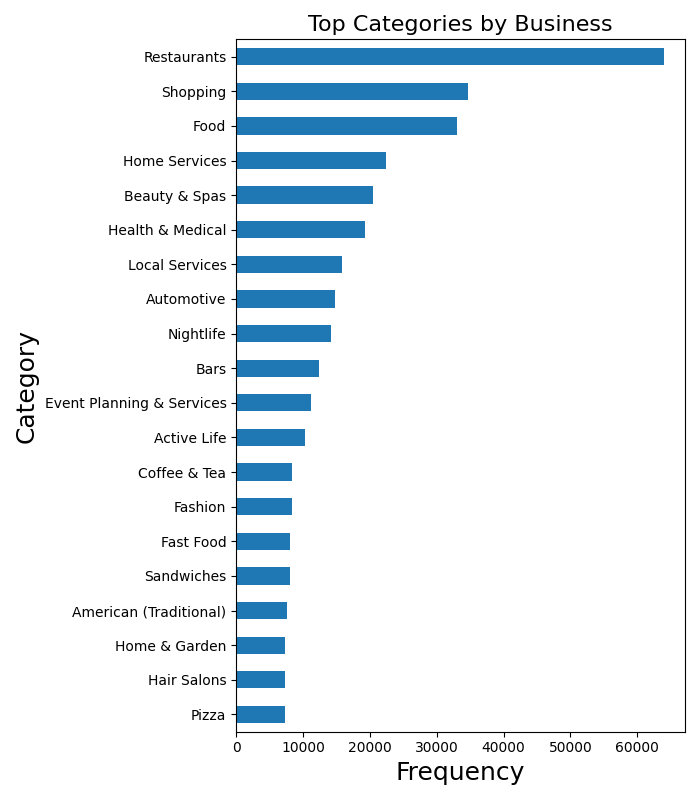

In [19]:
plt.clf()
df5.plot(kind='barh',x = 'category',figsize=(7,8),style = 'fivethirtyeight', legend = False).invert_yaxis()
plt.title('Top Categories by Business', size = 16)
plt.xlabel('Frequency',size =18, color = 'Black')
plt.ylabel('Category',size = 18, color = 'Black')
plt.tight_layout()
plt.show()
%matplot plt



# Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.
How true is this really? Let's try and answer this question.
Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [18]:
dfu = spark.read.json('s3://dwbucket2020/yelp_academic_dataset_review.json')
print(f'Total Columns: {len(dfu.dtypes)}')
print(f'Total Rows: {dfu.count():,}')
dfu.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 8,021,122
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

## We filter only  those ratings where review has been left. Hence:

In [20]:
dfun = dfu.where(f.col("text").isNotNull())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
dfu1 = dfun.select('business_id','stars')
dfu1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

### Calculate Average of  those reviews and compare them to  business's  average by joining tables:

In [22]:
dfu2 = dfu1.groupBy('business_id').agg(f.avg('stars').alias('avstars'))
dfu2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|           avstars|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

In [23]:
newdf = df.join(dfu2, df.business_id == dfu2.business_id).select('avstars','stars','name','city','state').sort(f.desc("stars"))
newdf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----+--------------------+---------+-----+
|          avstars|stars|                name|     city|state|
+-----------------+-----+--------------------+---------+-----+
|4.833333333333333|  5.0|Pure Healthy Cosm...|Las Vegas|   NV|
|              5.0|  5.0|Carbonation Craft...|Cornelius|   NC|
|              5.0|  5.0|       The Elf Squad|Charlotte|   NC|
|              5.0|  5.0|           Grandiose|  Phoenix|   AZ|
|              5.0|  5.0|Andre Agassi Coll...|Las Vegas|   NV|
+-----------------+-----+--------------------+---------+-----+
only showing top 5 rows

### Calculate a new column  of skewness  to  see whether the distribution is positively or negatively skewed

In [24]:
finaldf = newdf.withColumn('skew', (newdf.avstars - newdf.stars)/newdf.stars)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
pdframe = finaldf.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
pdframe.isnull().sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

avstars    0
stars      0
name       0
city       0
state      0
skew       0
dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

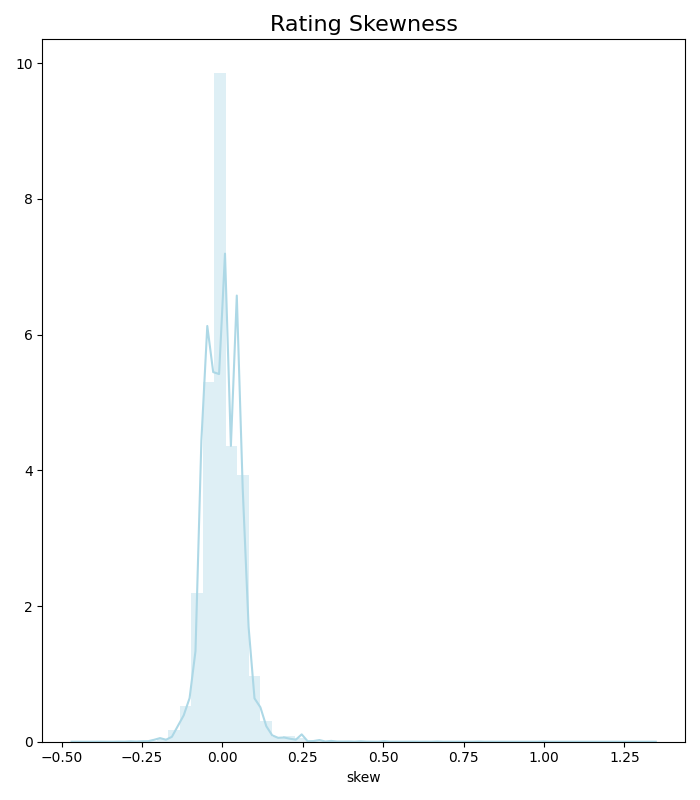

In [28]:
plt.clf()
sns.distplot(pdframe['skew'], hist = True, color = 'lightblue')
plt.title('Rating Skewness', size = 16)
plt.tight_layout()
plt.show()
%matplot plt



###  The graph seems to be positively skewed, however the skewness is not  very noticable, meaning that most people  who leave review and rating usually  are more satisfied woth service than those who only  leave a star rating, however there isnt substantial  difference to confidently infer.

# Should the Elite be Trusted? 
Next we want to  check  whether Elite's ratings are accurate.  For  that we want to compare average review left by  an elite yelper to  the average review of business

In [29]:
dfr = spark.read.json('s3://dwbucket2020/yelp_academic_dataset_user.json')
print(f'Total Columns: {len(dfr.dtypes)}')
print(f'Total Rows: {dfr.count():,}')
dfr.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 22
Total Rows: 1,968,703
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

### First, we remove all  yelpers who never been part of elite club
 We will then need to join user dataset with review dataset  to get the date of the review and check whether the reviewer was part of elite club at the time of the review

In [30]:
pp = dfr.filter("elite != ''")
pp.select('user_id','elite').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
|z5_82komKV3mI4ASG...|                2007|
+--------------------+--------------------+
only showing top 5 rows

In [31]:
newdfr = pp.join(dfu, pp.user_id == dfu.user_id).select('elite','business_id','stars','date')
newdfr.show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+-------------------+
|               elite|         business_id|stars|               date|
+--------------------+--------------------+-----+-------------------+
|2011,2012,2013,20...|L772e6l2Yd0DJEyCB...|  4.0|2014-09-19 01:12:10|
|2007,2008,2009,20...|DYuOxkW4DtlJsTHdx...|  3.0|2007-08-20 13:34:11|
|2007,2008,2009,20...|939j88ceB05Te3D7k...|  4.0|2007-08-20 17:27:53|
|2007,2008,2009,20...|BLIJ-p5wYuAhw6Pp6...|  3.0|2016-01-01 05:28:50|
|2007,2008,2009,20...|5iSmZO0SrKU6EoXK_...|  2.0|2007-08-20 00:44:28|
+--------------------+--------------------+-----+-------------------+
only showing top 5 rows

In [32]:
#user defined function  to check  if yelper was elite at time of review 
def check(a,b):
    for i in a:
        if b in a:
            return True
        else:
            return False
udf_check = udf(check)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

True

In [33]:
#new dataset to be ready  to be joined with business dataset 
pp1 = newdfr.select('business_id','stars','date',
    f.split("elite", ",").alias('year_elite'))
pp2 = pp1.select('business_id','stars','year_elite',
                 f.year("date").cast(types.StringType()).alias('year_only'))
pp3 = pp2.filter(udf_check(f.col('year_elite'),f.col('year_only'))==True)
pp4 = pp3.groupBy('business_id').agg(f.avg('stars').alias('avstars'))
pp4.show(5)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|           avstars|
+--------------------+------------------+
|BD18SKv935HDmlKrL...|               4.5|
|j2bx_ctb_ED3zbfSa...|  4.28140703517588|
|--9e1ONYQuAa-CB_R...| 4.240641711229946|
|56HZLqQOcS1FSXqYG...|4.5285714285714285|
|2UgRg5a6KmpbD_SZf...| 4.326086956521739|
+--------------------+------------------+
only showing top 5 rows

### Next  we  groupby  and compare ratings of business with ratings of business left by elite club to get a skewness and plot into  histogram  for visual  analysis

In [34]:
pp5 = df.join(pp4, df.business_id == pp4.business_id).select('avstars','stars','name','city','state').sort(f.desc("stars"))
newdf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----+--------------------+---------+-----+
|          avstars|stars|                name|     city|state|
+-----------------+-----+--------------------+---------+-----+
|              5.0|  5.0|Team Beauregard B...|     Mesa|   AZ|
|              5.0|  5.0|    Carpet Closeouts|  Phoenix|   AZ|
|4.888888888888889|  5.0|Camelback Sports ...|  Phoenix|   AZ|
|4.888888888888889|  5.0|      Stango Cuisine|   Urbana|   IL|
|4.784810126582278|  5.0|Green Valley Smil...|Henderson|   NV|
+-----------------+-----+--------------------+---------+-----+
only showing top 5 rows

In [35]:
pp6 = pp5.withColumn('skew', (pp5.avstars - pp5.stars)/pp5.stars)
pandafr = pp6.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

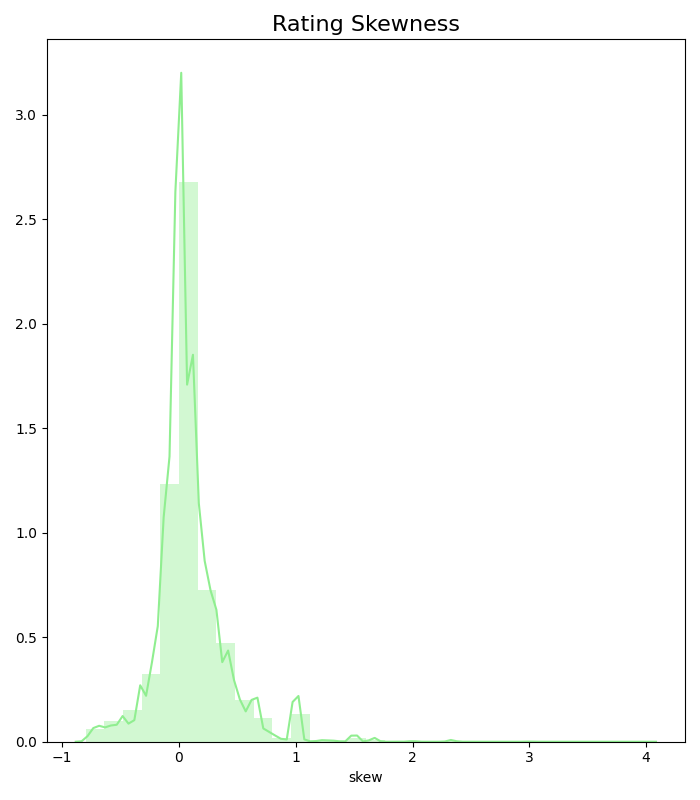

In [37]:
plt.clf()
sns.distplot(pandafr['skew'], bins = 30, hist = True, color = 'lightgreen') 
plt.title('Rating Skewness', size = 16)
plt.tight_layout()
plt.show()
%matplot plt

###  The graph  seems to be positvely skewed,  which  indicates that most elite reviewers leave more positive reviews than average of business. This could  potentially  show some bias that eliter members may have, or some promos/ sponsoring